[*********************100%***********************]  6 of 6 completed



✅ Tickers used: ['INFY.NS', 'TCS.NS', 'RELIANCE.NS', 'HDFCBANK.NS', 'ITC.NS', 'ADANIGREEN.NS']

Max Sharpe Portfolio Summary
- Expected Annual Return: 31.93%
- Annual Volatility: 23.13%
- Sharpe Ratio: 1.12
- Expected Portfolio Value (1-Year): ₹131,935
- Weights:
  INFY.NS: 40.57%
  TCS.NS: 0.00%
  RELIANCE.NS: 0.00%
  HDFCBANK.NS: 0.00%
  ITC.NS: 30.80%
  ADANIGREEN.NS: 28.64%
Simulated Final Portfolio Value (mean): ₹138,125
VaR (95% confidence): ₹-8,836
CVaR (95% confidence): ₹-16,256


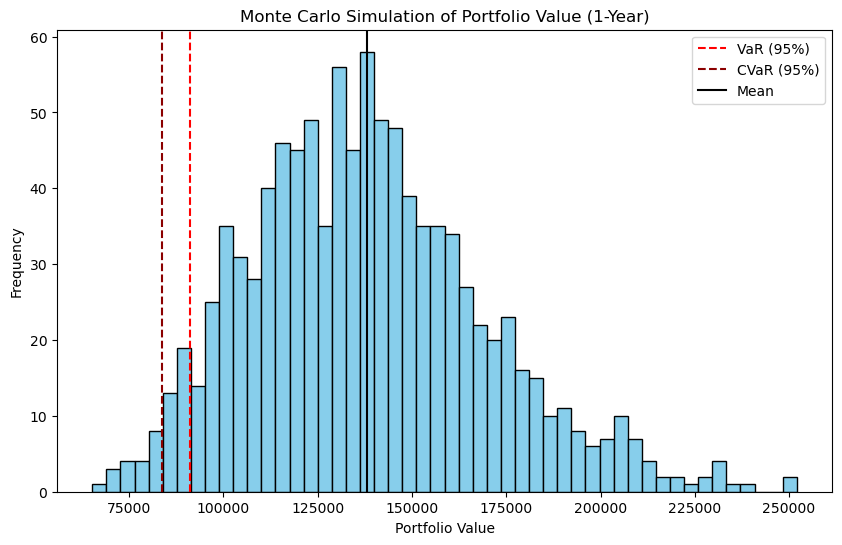


Min Variance Portfolio Summary
- Expected Annual Return: 19.88%
- Annual Volatility: 18.19%
- Sharpe Ratio: 0.76
- Expected Portfolio Value (1-Year): ₹119,876
- Weights:
  INFY.NS: 5.63%
  TCS.NS: 31.14%
  RELIANCE.NS: 7.17%
  HDFCBANK.NS: 19.97%
  ITC.NS: 30.88%
  ADANIGREEN.NS: 5.22%
Simulated Final Portfolio Value (mean): ₹121,854
VaR (95% confidence): ₹-11,174
CVaR (95% confidence): ₹-16,749


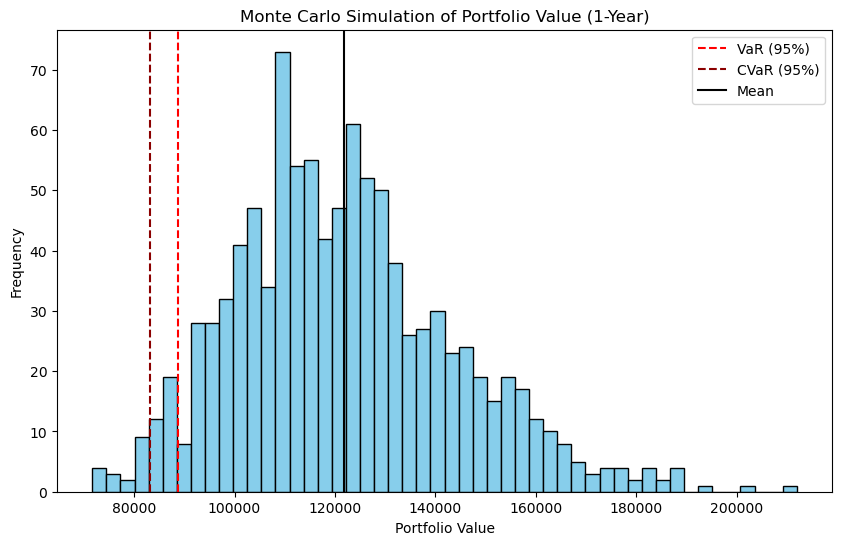

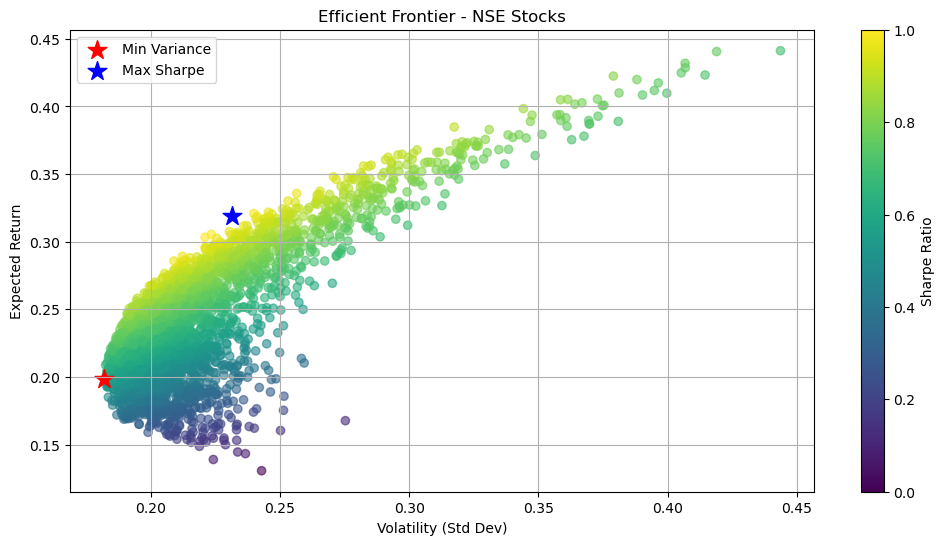

In [3]:
# Efficient Frontier + Monte Carlo VaR/CVaR for Indian Stocks

!pip install yfinance numpy pandas matplotlib seaborn scipy --quiet

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ----------------------- USER SETTINGS ----------------------------
tickers = ['INFY.NS', 'TCS.NS', 'RELIANCE.NS', 'HDFCBANK.NS', 'ITC.NS', 'ADANIGREEN.NS']
investment_amount = 100000  # in INR
start_date = '2020-01-01'
end_date = '2024-12-31'
risk_free_rate = 0.06  # annual risk-free rate

# ----------------------- STEP 1: Download Data ----------------------------
def download_nse_data(tickers, start, end):
    df = yf.download(tickers, start=start, end=end, group_by='ticker', auto_adjust=True)
    found_tickers = []
    
    if isinstance(df.columns, pd.MultiIndex):
        price_df = pd.DataFrame()
        for t in tickers:
            try:
                price_df[t] = df[t]['Close']
                found_tickers.append(t)
            except KeyError:
                print(f"⚠️ Warning: Data for {t} not found.")
    else:
        price_df = df[['Close']]
        price_df.columns = tickers[:1]
        found_tickers = tickers[:1]
    
    print(f"\n✅ Tickers used: {found_tickers}")
    return price_df.dropna()

prices = download_nse_data(tickers, start_date, end_date)

# ----------------------- STEP 2: Returns & Covariance ----------------------
returns = prices.pct_change().dropna()
mean_returns = returns.mean()
cov_matrix = returns.cov()

# ----------------------- STEP 3: Portfolio Stats ---------------------------
def portfolio_stats(weights, mean_returns, cov_matrix, rf=risk_free_rate):
    port_return = np.dot(weights, mean_returns) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe = (port_return - rf) / port_vol
    return port_return, port_vol, sharpe

# ----------------------- STEP 4: Optimization ------------------------------
def optimize_portfolios():
    num_assets = len(tickers)
    bounds = tuple((0, 1) for _ in range(num_assets))
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    init_guess = num_assets * [1. / num_assets]

    def min_variance(weights):
        return portfolio_stats(weights, mean_returns, cov_matrix)[1]  # volatility

    def neg_sharpe(weights):
        return -portfolio_stats(weights, mean_returns, cov_matrix)[2]

    min_var = minimize(min_variance, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    max_sharpe = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

    return min_var.x, max_sharpe.x

# ----------------------- STEP 5: Efficient Frontier ------------------------
def plot_efficient_frontier():
    results = {'Returns': [], 'Volatility': [], 'Sharpe': []}
    for _ in range(3000):
        weights = np.random.dirichlet(np.ones(len(mean_returns)))
        ret, vol, sharpe = portfolio_stats(weights, mean_returns, cov_matrix)
        results['Returns'].append(ret)
        results['Volatility'].append(vol)
        results['Sharpe'].append(sharpe)

    plt.figure(figsize=(12, 6))
    plt.scatter(results['Volatility'], results['Returns'], c=results['Sharpe'], cmap='viridis', alpha=0.6)

    # Plot optimal portfolios
    min_weights, max_weights = optimize_portfolios()
    min_ret, min_vol, _ = portfolio_stats(min_weights, mean_returns, cov_matrix)
    max_ret, max_vol, _ = portfolio_stats(max_weights, mean_returns, cov_matrix)

    plt.scatter(min_vol, min_ret, color='red', marker='*', s=200, label='Min Variance')
    plt.scatter(max_vol, max_ret, color='blue', marker='*', s=200, label='Max Sharpe')

    plt.title("Efficient Frontier - NSE Stocks")
    plt.xlabel("Volatility (Std Dev)")
    plt.ylabel("Expected Return")
    plt.colorbar(label='Sharpe Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

# ----------------------- STEP 6: Monte Carlo VaR/CVaR ----------------------
def monte_carlo_sim(weights, mean_returns, cov_matrix, initial_investment, days=252, simulations=1000):
    portfolio_mean = np.dot(weights, mean_returns)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    sim_results = []
    for _ in range(simulations):
        daily_returns = np.random.normal(loc=portfolio_mean, scale=portfolio_std, size=days)
        portfolio_value = initial_investment * np.prod(1 + daily_returns)
        sim_results.append(portfolio_value)

    sim_results = np.array(sim_results)

    VaR = np.percentile(sim_results, 5)
    CVaR = sim_results[sim_results < VaR].mean()

    print(f"Simulated Final Portfolio Value (mean): ₹{sim_results.mean():,.0f}")
    print(f"VaR (95% confidence): ₹-{initial_investment - VaR:,.0f}")
    print(f"CVaR (95% confidence): ₹-{initial_investment - CVaR:,.0f}")

    plt.figure(figsize=(10, 6))
    plt.hist(sim_results, bins=50, color='skyblue', edgecolor='black')
    plt.axvline(VaR, color='red', linestyle='--', label='VaR (95%)')
    plt.axvline(CVaR, color='darkred', linestyle='--', label='CVaR (95%)')
    plt.axvline(sim_results.mean(), color='black', linestyle='-', label='Mean')
    plt.title("Monte Carlo Simulation of Portfolio Value (1-Year)")
    plt.xlabel("Portfolio Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# ----------------------- STEP 7: Summary Print -----------------------------
def print_portfolio_summary(weights, name):
    port_return, port_vol, sharpe = portfolio_stats(weights, mean_returns, cov_matrix)
    expected_value = investment_amount * (1 + port_return)

    print(f"\n{name} Portfolio Summary")
    print(f"- Expected Annual Return: {port_return:.2%}")
    print(f"- Annual Volatility: {port_vol:.2%}")
    print(f"- Sharpe Ratio: {sharpe:.2f}")
    print(f"- Expected Portfolio Value (1-Year): ₹{expected_value:,.0f}")
    print("- Weights:")
    for t, w in zip(tickers, weights):
        print(f"  {t}: {w:.2%}")

# ----------------------- Run Full Pipeline -----------------------------
min_weights, max_weights = optimize_portfolios()

print_portfolio_summary(max_weights, "Max Sharpe")
monte_carlo_sim(max_weights, mean_returns, cov_matrix, investment_amount)

print_portfolio_summary(min_weights, "Min Variance")
monte_carlo_sim(min_weights, mean_returns, cov_matrix, investment_amount)

plot_efficient_frontier()
